In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch

from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from tqdm import tqdm

/tmp/ipykernel_108843/822992949.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-19 08:13:36.406107: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-19 08:13:36.439712: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 08:13

In [4]:
channel_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06','Cloud_B07',
                 'Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']

data_water=parse.parse('cloudrm_water_black_surf.dat')
data_clear=parse.parse('cloudrm_clear_black_surf.dat')
data_ice=parse.parse('cloudrm_ice_black_surf.dat')
data_mixed=parse.parse('cloudrm_mixed_black_surf.dat')

#Concatinate all datasets
data_all=pd.concat([data_water, data_clear, data_ice, data_mixed])
data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
df_truth=data_all.copy()

#data_all=hf.add_MSI_noise(data_all,channel_labels)

In [5]:
data_all

,Cloud_B02,Cloud_B03,Cloud_B04,Cloud_B05,Cloud_B06,Cloud_B07,Cloud_B08,Cloud_B09,Cloud_B10,Cloud_B11,...,Clear_B12,Clear_B13,Sat_Zenith_Angle,Sun_Zenith_Angle,Azimuth_Diff_Angle,COT,Cloud_Type,Profile_ID,GOT,Water_Vapor
0,0.59845,0.56035,0.58520,0.59223,0.60114,0.60779,0.59733,0.61405,0.38434,0.03711,...,0.00057,0.0,4.35,56.99,22.96,23.397,2,8973,0.129,6.37
1,0.17238,0.13562,0.12377,0.12365,0.12193,0.12057,0.11932,0.11895,0.09423,0.01680,...,0.00058,0.0,12.27,60.32,81.41,2.452,2,3598,0.123,0.46
2,0.31040,0.27631,0.28027,0.28470,0.28608,0.28737,0.28547,0.28867,0.20128,0.01345,...,0.00053,0.0,2.12,55.76,50.24,6.564,5,9625,0.122,0.69
3,0.71028,0.67801,0.71760,0.72312,0.73710,0.74916,0.73144,0.76126,0.40760,0.00615,...,0.00049,0.0,1.46,44.21,106.95,29.710,3,6165,0.128,2.96
4,0.59586,0.56908,0.60396,0.61882,0.62700,0.63354,0.63540,0.64263,0.55407,0.17561,...,0.00034,0.0,12.33,40.58,172.91,17.975,4,2862,0.105,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.53386,0.48130,0.50760,0.52080,0.52618,0.52768,0.52381,0.52922,0.43667,0.07800,...,0.00077,0.0,7.37,70.07,40.61,11.154,10,4023,0.123,0.85
49996,0.64939,0.61187,0.63110,0.64144,0.64440,0.64517,0.64352,0.64558,0.59570,0.25027,...,0.00043,0.0,5.06,39.36,3.69,18.838,11,3253,0.110,0.28
49997,0.78946,0.74886,0.77966,0.78072,0.79273,0.80177,0.77838,0.80867,0.50618,0.07686,...,0.00045,0.0,7.75,43.19,157.29,40.314,9,5982,0.128,4.28
49998,0.69434,0.64678,0.67630,0.64869,0.67461,0.70068,0.64862,0.71872,0.29174,0.01036,...,0.00052,0.0,6.89,59.56,156.13,26.983,10,8629,0.128,5.19


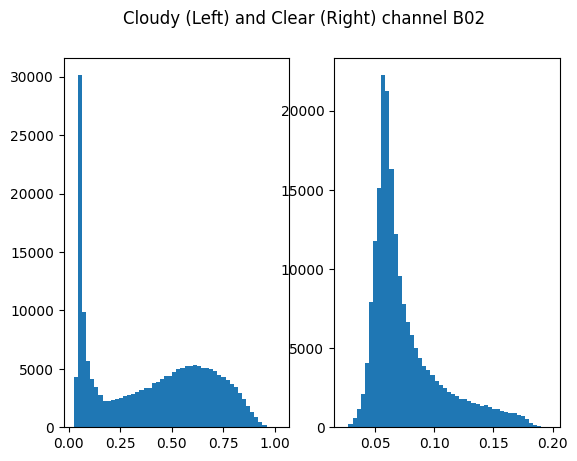

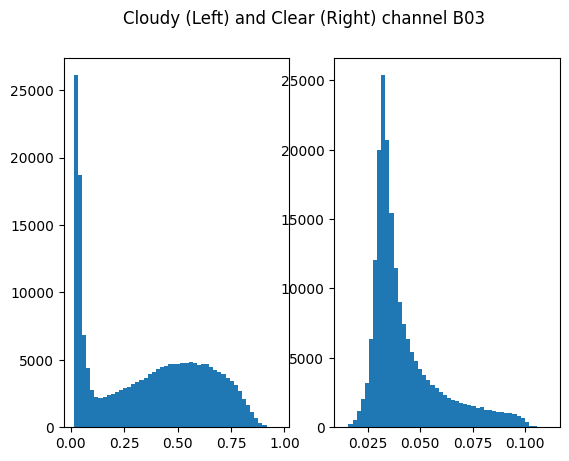

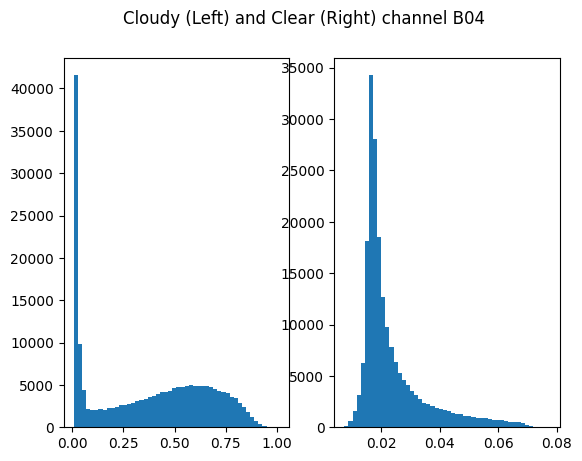

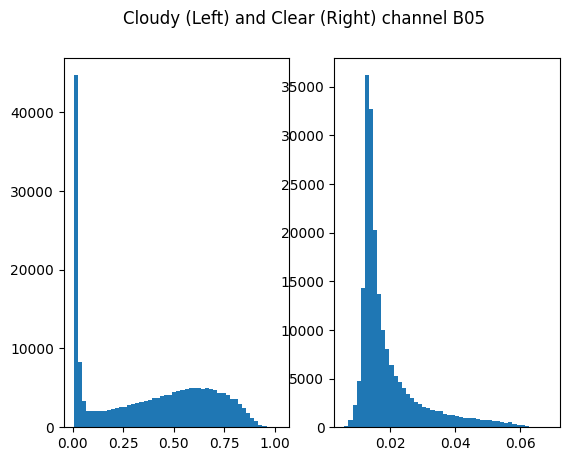

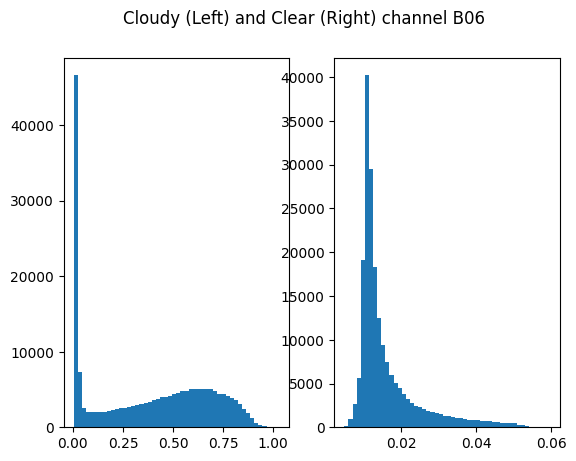

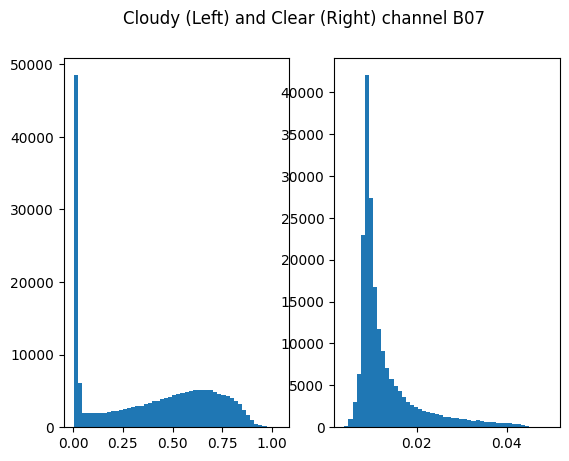

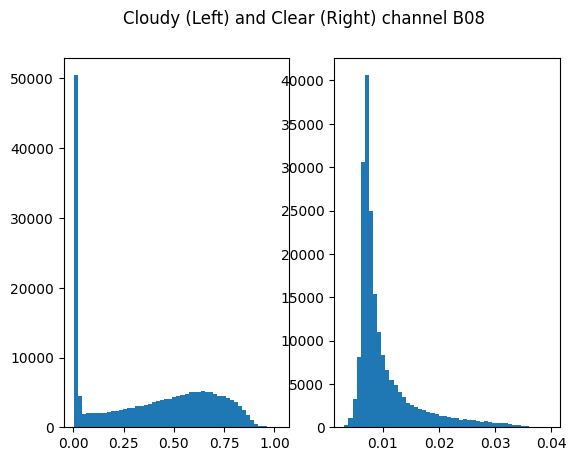

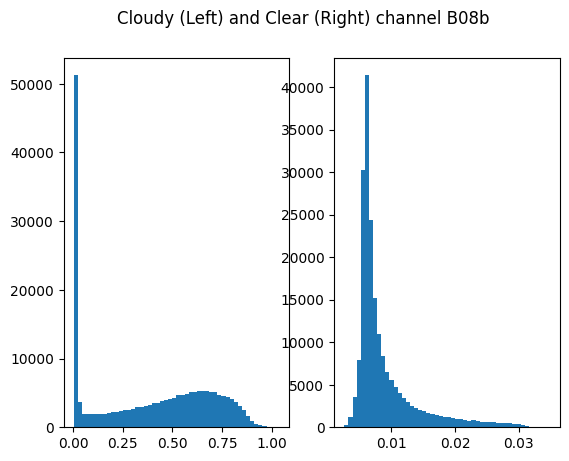

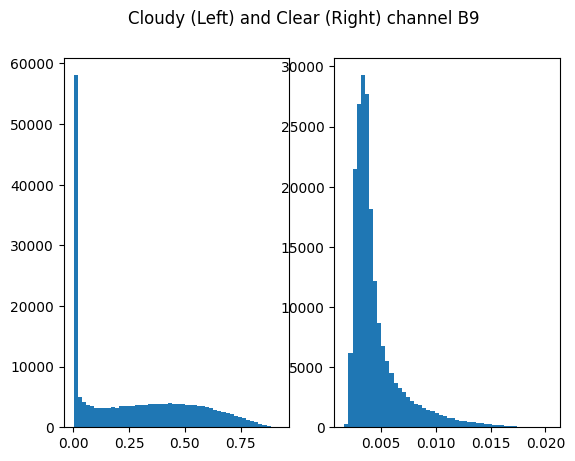

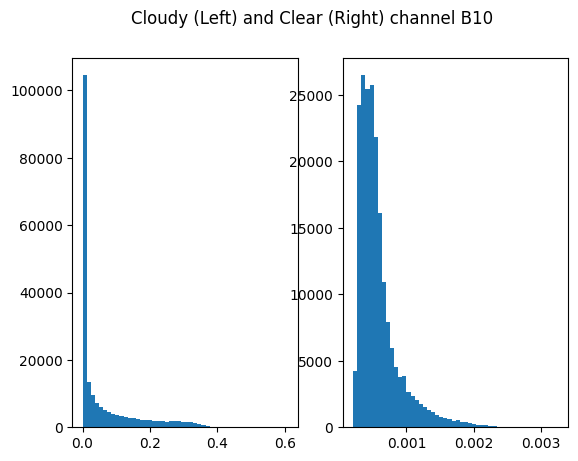

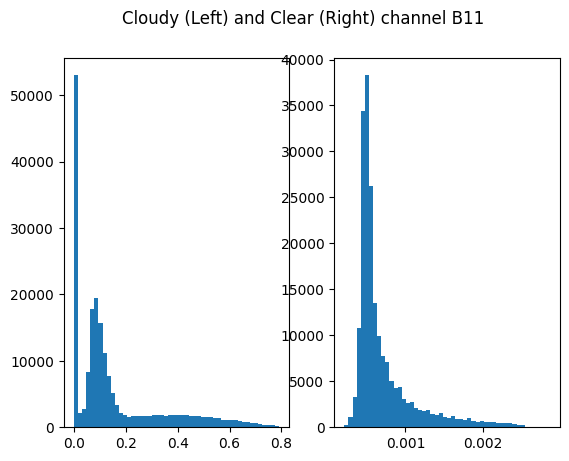

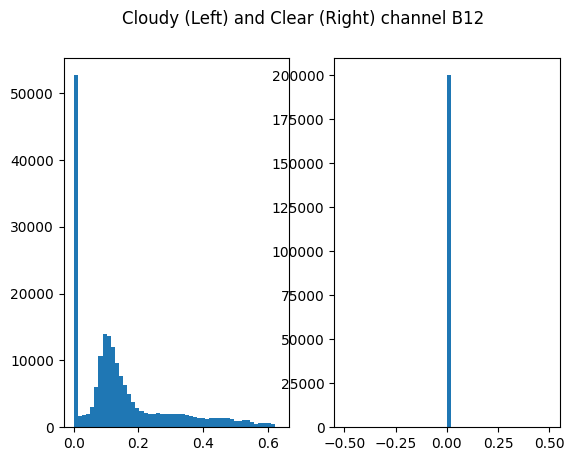

In [8]:
for i in range(2,14):
    fig, (ax1, ax2) = plt.subplots(1,2)
    
    if i<=9:
        if i==9:
            fig.suptitle("Cloudy (Left) and Clear (Right) channel B08b")
            ax1.hist(data_all['Cloud_'+'B0'+str(i)],bins=50)
            ax2.hist(data_all['Clear_'+'B0'+str(i)],bins=50)
        else:
            fig.suptitle("Cloudy (Left) and Clear (Right) channel B0"+str(i))
            ax1.hist(data_all['Cloud_'+'B0'+str(i)],bins=50)
            ax2.hist(data_all['Clear_'+'B0'+str(i)],bins=50)
    else:
        fig.suptitle("Cloudy (Left) and Clear (Right) channel B"+str(i-1))
        ax1.hist(data_all['Cloud_'+'B'+str(i)],bins=50)
        ax2.hist(data_all['Clear_'+'B'+str(i)],bins=50)